In [1]:
import numpy as np
import libelastic.all as le
from pylab import *
import time

We first work on two metals, iron and copper.
Here define material property, C11, C12, C44.

The external stress is defined as Sigma_E with Voigt notation (11 → 1, 22 → 2, 33 → 3, 23 → 4, 13 → 5, 12 → 6).
Here Sigma_E is 100MPa compressive stress, along Y direction.

Therefore the elastic matrix and compliance matrix are obtained.

In [2]:
MaterialPropList = {'Fe':[237,141,116],'Cu':[159,129,79]}
Mater = 'Fe'
Sigma_E = np.array([0,-100.0,0,0,0,0]).reshape((6,1))
Elastic = le.Tensor(MaterialPropList[Mater][0],MaterialPropList[Mater][1],MaterialPropList[Mater][2])
Compliance_matrix = np.linalg.pinv(le.Transform9(Elastic))
Compliance = le.Reverse(Compliance_matrix)

Here define the orientation of the two grains.
The basis vector of rotation matrix is the Miller indices along global X, Y, Z axis of the grain.

Here we choose the configuration with the maximum incompatibility.
The Miller indices corresponding to Global Y-axis are $[0 1 0]$ and $[1 1 1]$ for the grain 1 and 2.
The rotation matrix (RM) should be normalized.

In [3]:
RM1 = [[1,0,0],[0,1,0],[0,0,1]]

V2_1 = [1,-1,0]
V2_2 = [1,1,1]
V2_3 = [-1,-1,2]
V2_1 = V2_1 / np.linalg.norm(V2_1)
V2_2 = V2_2 / np.linalg.norm(V2_2)
V2_3 = V2_3 / np.linalg.norm(V2_3)
RM2 = [V2_1,V2_2,V2_3]

RM1 = np.asarray(RM1)
RM2 = np.asarray(RM2)

The compliance matrices S1 and S2 for the two grain are calculated with RotateComplianceTensor function.

The incompatibility stress (SigmaInc = Stress in Grain II  - Stress in Grain I) is then obtained. 

In [4]:
S1 = le.RotateComplianceTensor(Compliance,RM1)
S2 = le.RotateComplianceTensor(Compliance,RM2)
SigmaInc = le.MismatchStress_Comp(Sigma_E,S1,S2,Type = 2)
SigmaInc = np.ndarray.tolist(SigmaInc)
print(SigmaInc)

[[54.43776029613053], [2.2737367544323206e-13], [54.43776029612681], [3.581012998084404e-15], [1.1965875560202549e-12], [-1.0026078485139647e-15]]


The incompatibility factor (IF) is defined as $\Large\frac{\sigma_1 + \sigma_3}{\sigma^E}$.

In [5]:
SigmaInc = np.asarray(SigmaInc)
SigmaInc = SigmaInc.astype(float)
Stress1 = Sigma_E - 0.5 * SigmaInc
Stress2 = Sigma_E + 0.5 * SigmaInc
# Calculate incompatibility factor.
IF = (Stress1[0] + Stress1[2]) / Sigma_E[1][0]
print(IF)

[0.5443776]


[Richeton](https://www.tandfonline.com/doi/full/10.1080/14786435.2014.984787) proposed a compacted solution 
for the incompatibility stress, which yields same results as the method shown in the article.

When setting Type = 1, the solution is from Richeton et al.

When setting Type = 2, the solution is from this work.

Here it can be found that the two methods yield same result.

In [6]:
TrialNum = 5
for i in range(0,TrialNum):
    RM1 = le.RM_generator()
    RM2 = le.RM_generator()
    S1 = le.RotateComplianceTensor(Compliance,RM1)
    S2 = le.RotateComplianceTensor(Compliance,RM2)
    
    SigmaInc_1 = le.MismatchStress_Comp(Sigma_E,S1,S2,Type = 1)
    SigmaInc_1 = np.ndarray.tolist(SigmaInc_1)
    SigmaInc_1 = ['{:.1f}'.format(n[0]) for n in SigmaInc_1]
    print('Case',i+1,', method 1, IS is:',SigmaInc_1)
    SigmaInc_2 = le.MismatchStress_Comp(Sigma_E,S1,S2,Type = 2)
    SigmaInc_2 = np.ndarray.tolist(SigmaInc_2)
    SigmaInc_2 = ['{:.1f}'.format(n[0]) for n in SigmaInc_2]
    print('         method 2, IS is:',SigmaInc_2)

Case 1 , method 1, IS is: ['7.2', '0.0', '3.3', '0.0', '25.6', '0.0']
         method 2, IS is: ['7.2', '-0.0', '3.3', '-0.0', '25.6', '0.0']
Case 2 , method 1, IS is: ['-27.8', '0.0', '17.9', '0.0', '-14.3', '0.0']
         method 2, IS is: ['-27.8', '-0.0', '17.9', '0.0', '-14.3', '-0.0']
Case 3 , method 1, IS is: ['-30.3', '0.0', '-31.7', '0.0', '13.2', '0.0']
         method 2, IS is: ['-30.3', '0.0', '-31.7', '0.0', '13.2', '-0.0']
Case 4 , method 1, IS is: ['2.4', '0.0', '-18.3', '0.0', '-8.1', '0.0']
         method 2, IS is: ['2.4', '-0.0', '-18.3', '0.0', '-8.1', '-0.0']
Case 5 , method 1, IS is: ['21.9', '0.0', '22.0', '0.0', '17.0', '0.0']
         method 2, IS is: ['21.9', '0.0', '22.0', '0.0', '17.0', '0.0']


In the main text, the IF for general grain boundaries are estimated as:
$$
\begin{align}
  IF &\approx \frac{1/E_Y^I - 1/E_Y^{II}}{(F^{I}_{22} + F^{II}_{22})\chi+4s_{11}+4s_{12}}\\\
      & \approx \frac{6(1/E_Y^I - 1/E_Y^{II})}{10 s_{11}+14 s_{12}+s_{44}}.
\end{align}
$$
Here for 5000 bicrystals with random orientations, the exact value of IF are plotted with respect to $1/E_Y^I - 1/E_Y^{II}$, which shows a good linear relationship.

The Young's modulus of each grain is calculated with YoungsModulus function.

Text(0.5, 1.0, 'IF as a function of $1/E_Y^I - 1/E_Y^{II}$')

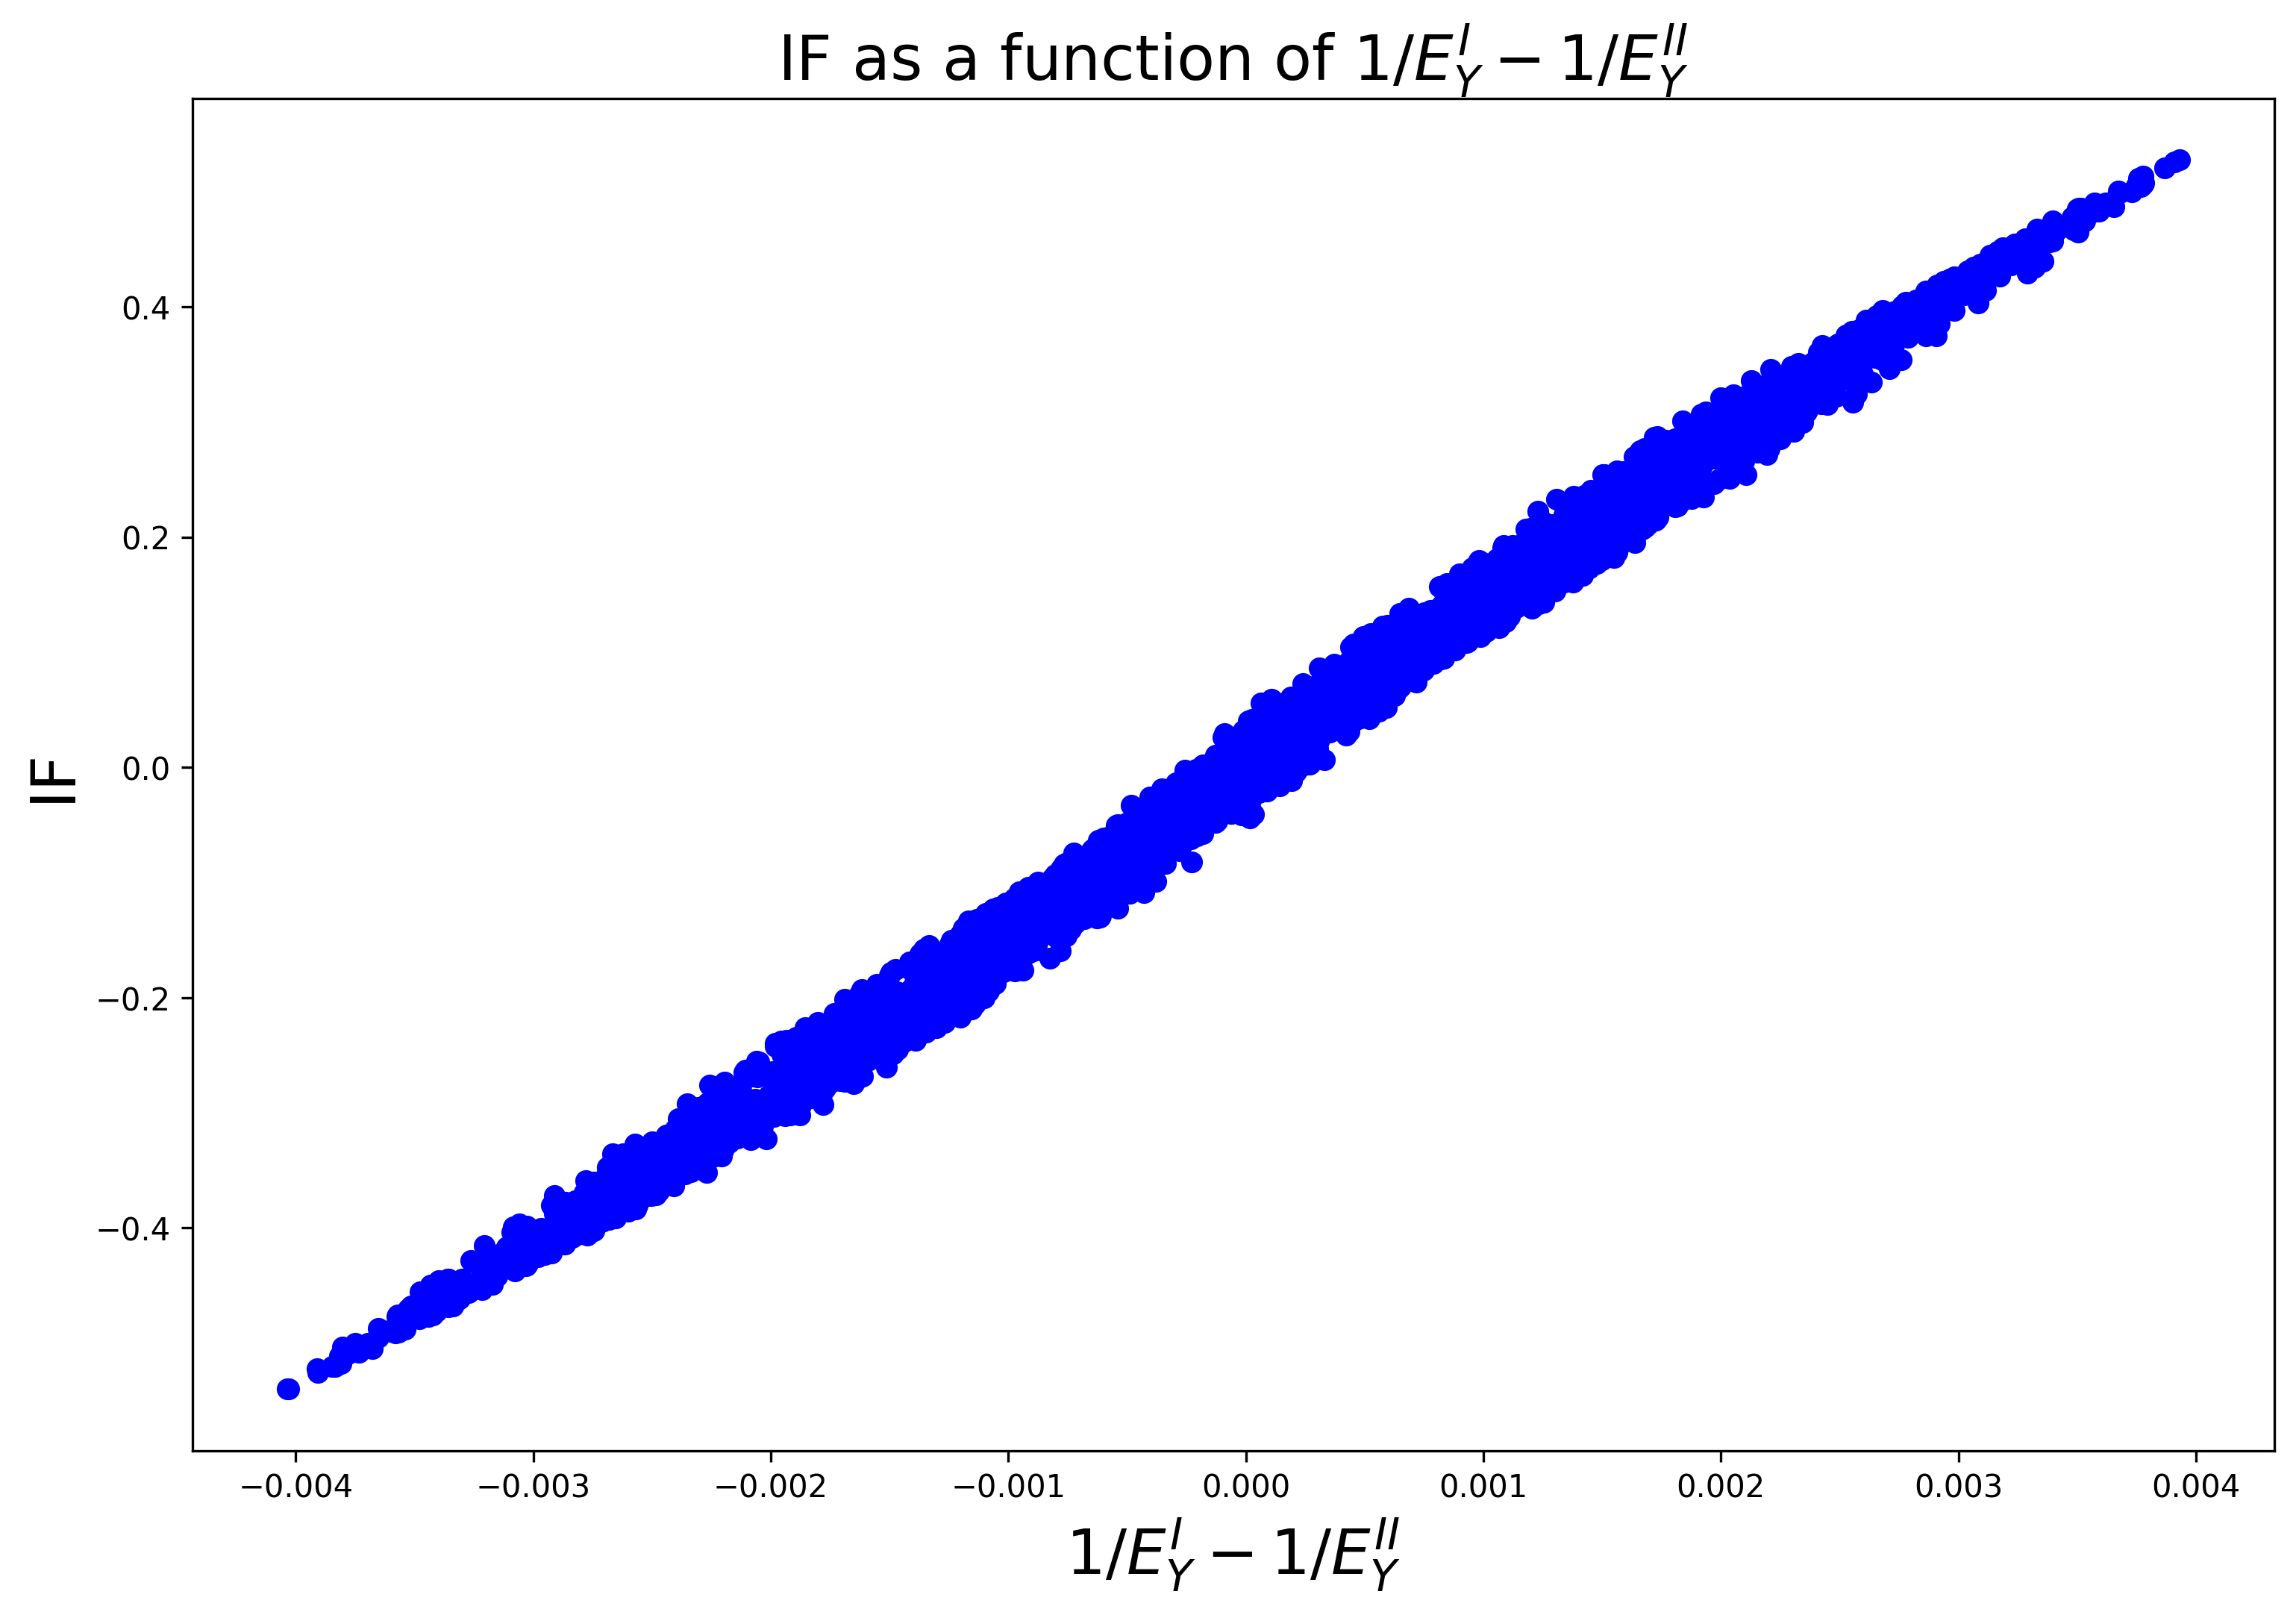

In [9]:
# Here the relation between 1/E1 - 1/E2 and IF is presented.
 
TrialNum = 5000
YoungsAll = []
IF = []
for i in range(0,TrialNum):
    RM1 = le.RM_generator()
    RM2 = le.RM_generator()
    S1 = le.RotateComplianceTensor(Compliance,RM1)
    S2 = le.RotateComplianceTensor(Compliance,RM2)
    YM1 = le.YoungsModulus([0,1,0],S1,'S')
    YM2 = le.YoungsModulus([0,1,0],S2,'S')
    DeltaYM = 1/YM1 - 1/YM2
    YoungsAll.append(DeltaYM)
    SigmaInc = le.MismatchStress_Comp(Sigma_E,S1,S2,Type = 1)
    SigmaInc = np.asarray(SigmaInc)
    SigmaInc = SigmaInc.astype(float)
    Stress1 = Sigma_E - 0.5 * SigmaInc
    Stress2 = Sigma_E + 0.5 * SigmaInc
    IF.append((Stress1[0] + Stress1[2]) / Sigma_E[1][0])
figure(figsize=(12,8),dpi=(300))
plot(YoungsAll,IF,'bo')
xlabel(r'$1/E_Y^I - 1/E_Y^{II}$',fontsize=20)
ylabel(r'IF',fontsize=20)
title(r'IF as a function of $1/E_Y^I - 1/E_Y^{II}$',fontsize=20)

The accurancy of above approximation is further revealed.

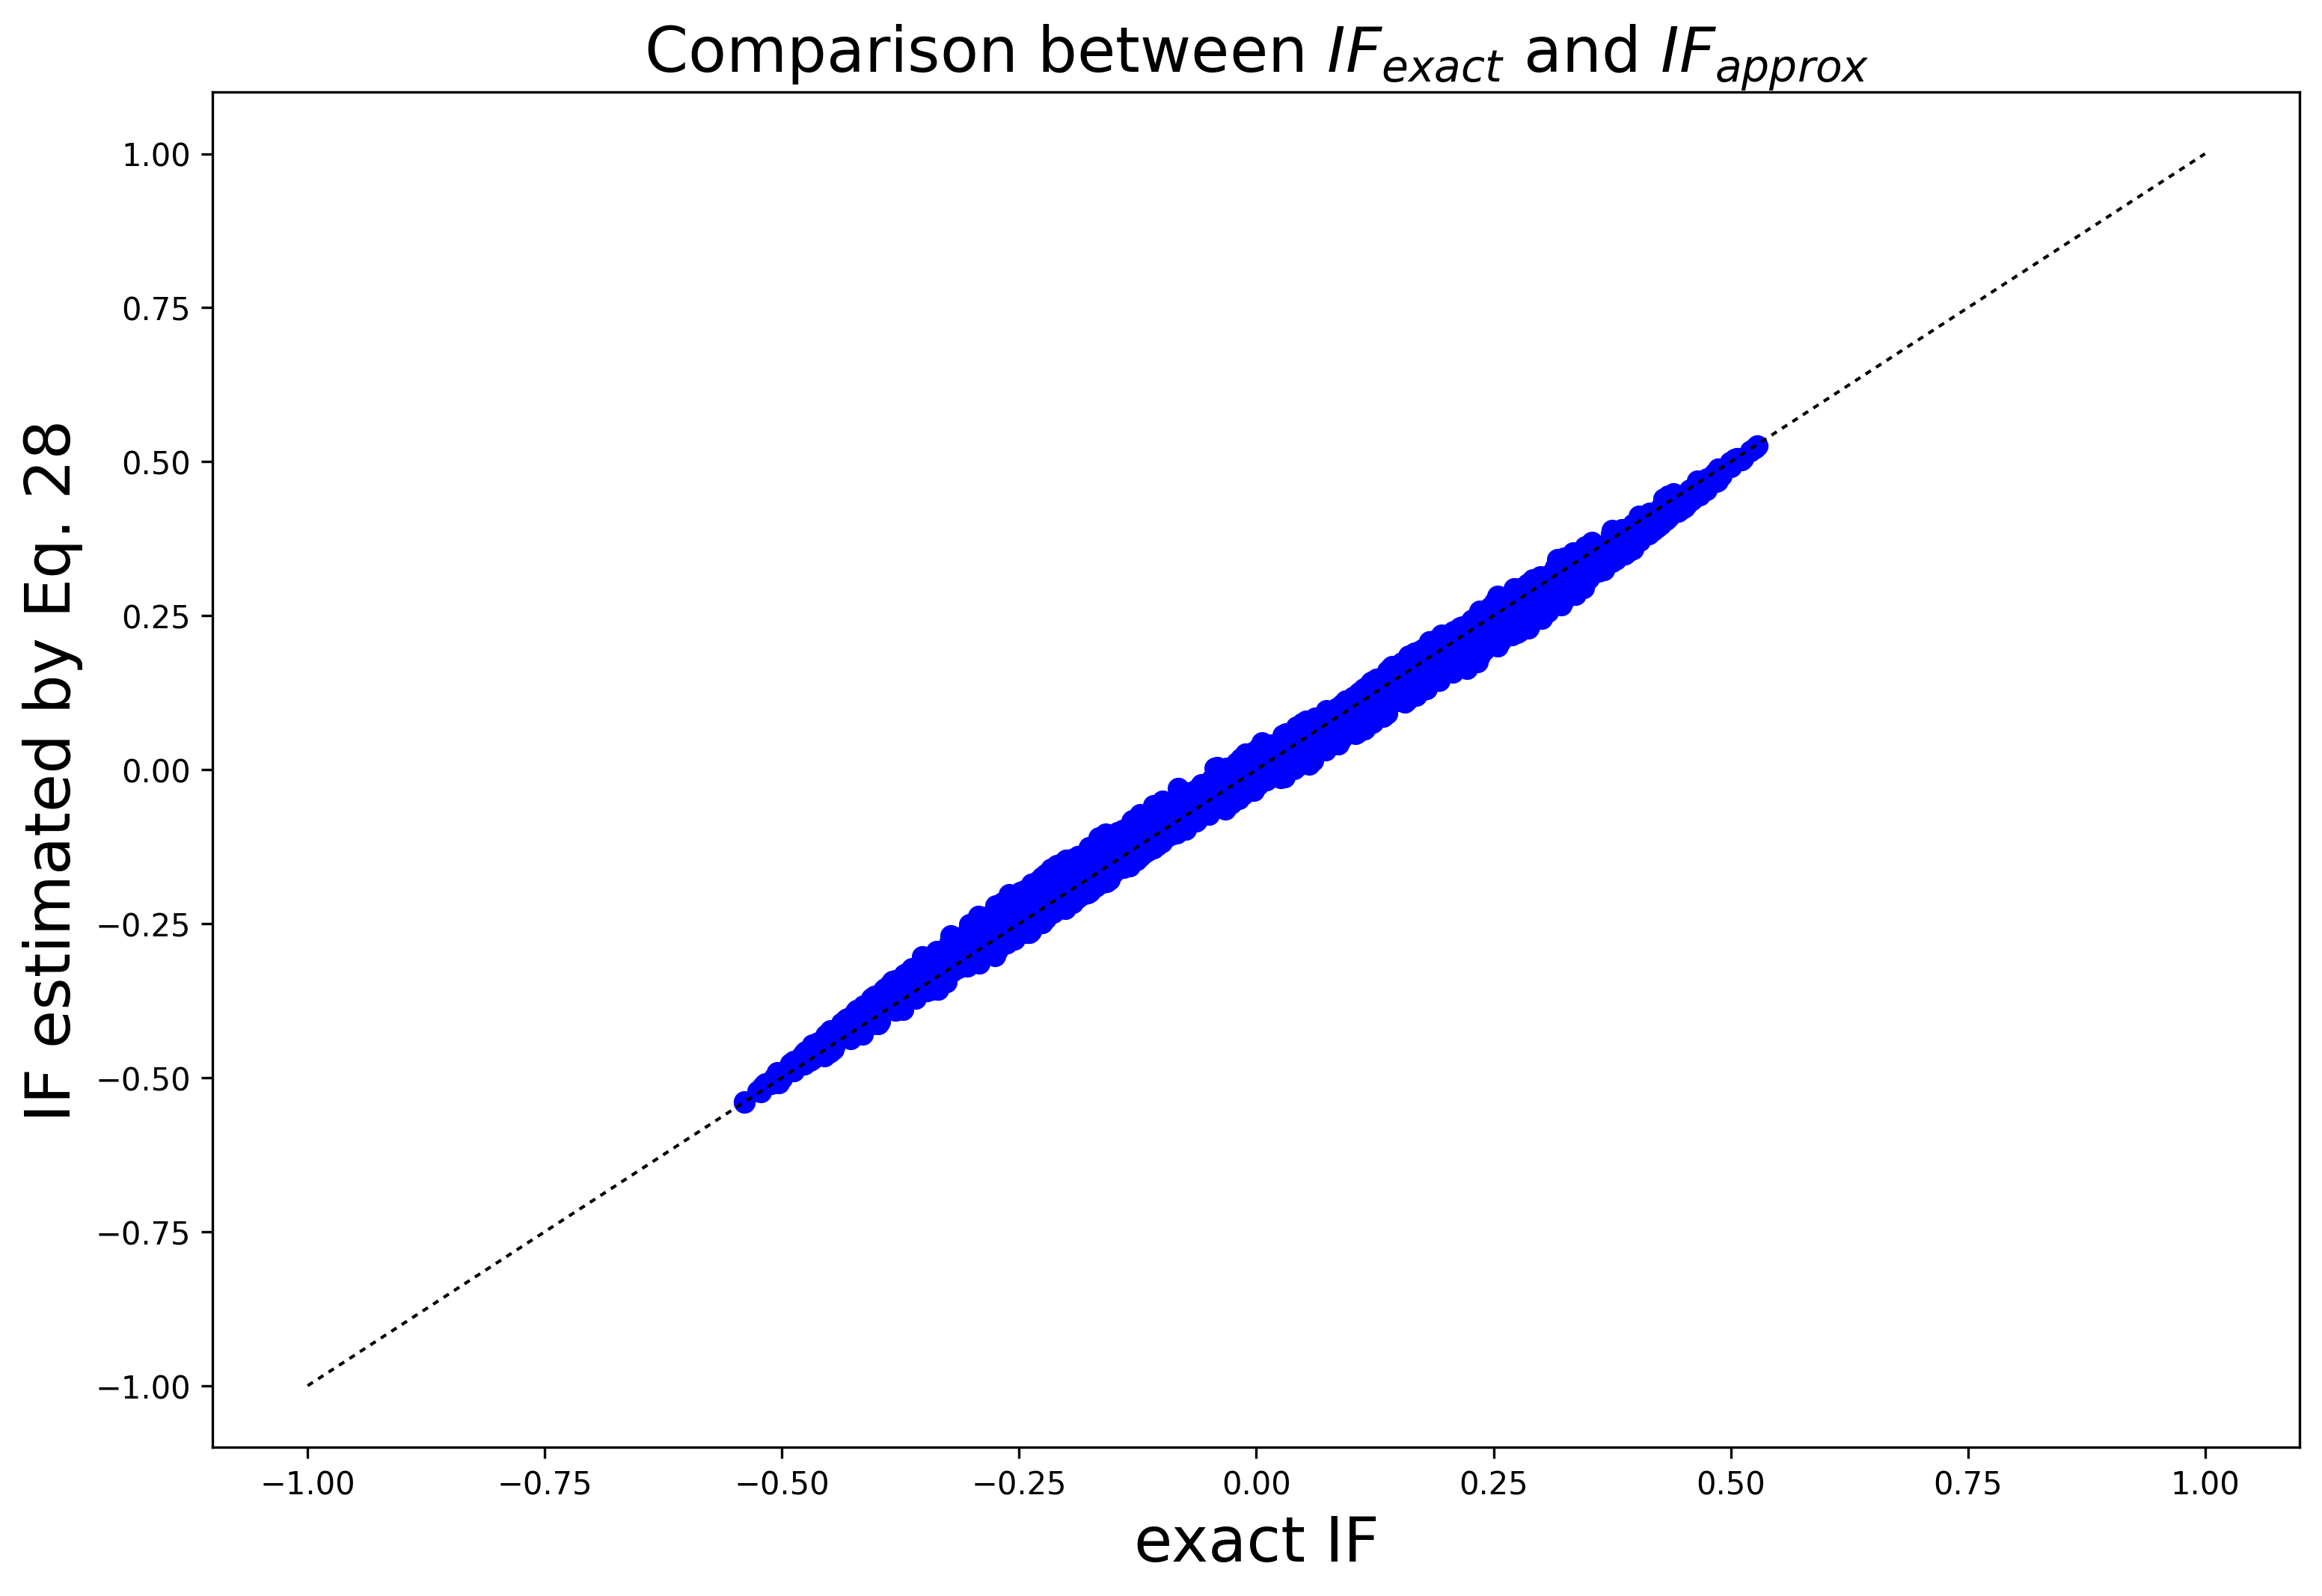

In [10]:
s11 = Compliance_matrix[0,0]
s12 = Compliance_matrix[0,1]
s44 = Compliance_matrix[3,3]*4 # Here s44 is multiplied by 4 since Voigt notation is applied.
factor = 6 / (10*s11+14*s12+s44)
IF_approx = [x * factor for x in YoungsAll]
figure(figsize=(12,8),dpi=(300))
plot(IF,IF_approx,'bo')
xlabel(r'exact IF',fontsize=20)
ylabel(r'IF estimated by Eq. 28',fontsize=20)
title(r'Comparison between $IF_{exact}$ and $IF_{approx}$',fontsize=20)
plt.plot([-1, 1], [-1, 1], 'k-', lw=1,dashes=[2, 2]) # Reference line

**Now we calculated the $IF^{max}$ for various metals.**

$$
\begin{align}
 IF^{max} &= \frac{2\chi/3}{-\chi/3+4s_{11}+4s_{12}}\\
    &= \frac{4s_{11}-4s_{12}-2 s_{44}}{10 s_{11}+14 s_{12}+s_{44}}\\
    &= \frac{-2\left(C_{11}-C_{12}-2 C_{44}\right)\left(C_{11}+2 C_{12}\right)}{\left(10 C_{11}-4 C_{12}\right) C_{44}+\left(C_{11}-C_{12}\right)\left(C_{11}+2 C_{12}\right)}.
\end{align}
$$

The material properties are read from *ElasticComponents.txt*.

In [11]:
Element = []
ElasticComponents = []
with open("ElasticComponents.txt") as f:
    for line in f:
        name, C11, C12, C44 = line.split()
        Element.append(name)
        ElasticComponents.append([float(C11),float(C12),float(C44)])
f.close()

In [12]:
IF_max = []
for index in range(len(Element)):
    C11,C12,C44 = ElasticComponents[index][0], ElasticComponents[index][1], ElasticComponents[index][2]
    IF_temp = -2*(C11-C12-2*C44)*(C11+2*C12)/((10*C11-4*C12)*C44+(C11-C12)*(C11+2*C12))
    IF_max.append(IF_temp)

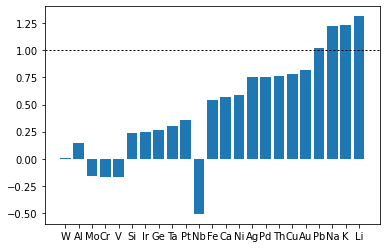

In [13]:
plt.bar(range(len(IF_max)), IF_max, tick_label=Element)
plt.axhline(y=1.0,linewidth=1, dashes=[2, 2],color='k')
plt.show()
